<a href="https://colab.research.google.com/github/Pengjp/gene_research/blob/master/5_6_k%3D3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns, numpy as np
from scipy.stats import entropy
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand,randint
from numpy.random import randn, exponential
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
import matplotlib.pyplot as plt
from keras import optimizers
import tensorflow as tf
from numpy.random import random, choice
import warnings

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


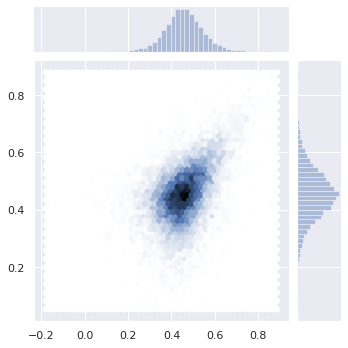

In [2]:
# Ploting
sns.set()
def generate_gaps(k, theta=1e-4, rho=1e-5):
    'generate k gaps according to the genetic distribution'
    pos = 0
    gaps = []
    while True:
        x = np.random.exponential()
        while True:
            y = np.random.exponential() / (x * (theta + rho))  # segment height
            last_pos = pos
            pos += y
            if np.random.rand() < (theta / (theta + rho)): # mutation generated
                gaps.append(pos - last_pos)
                if len(gaps) == k:
                    return(gaps)
            else:  # recombination generated
                break

data = np.log(np.array([generate_gaps(2) for _ in range(10000)])) / 20
sns.jointplot(data[:,0],data[:,1],kind='hex',size=5)

Epoch: 0


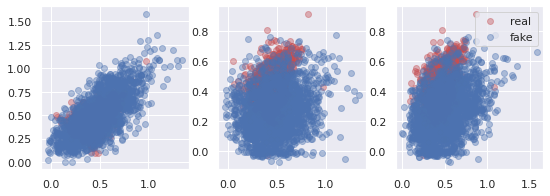

Epoch: 500


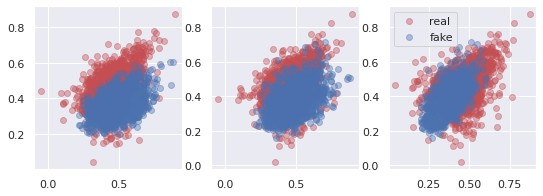

Epoch: 1000


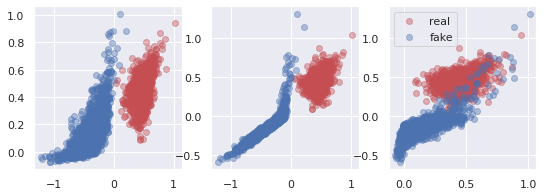

Epoch: 1500


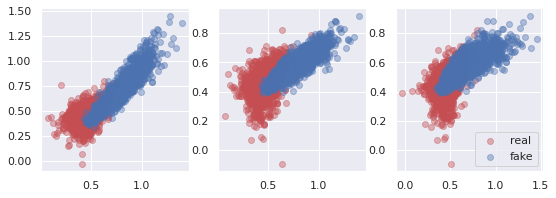

Epoch: 2000


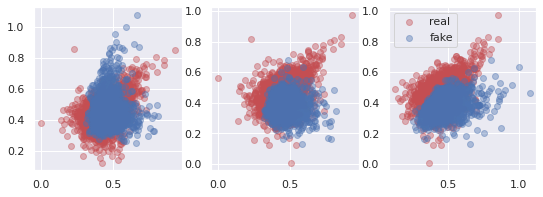

Epoch: 2500


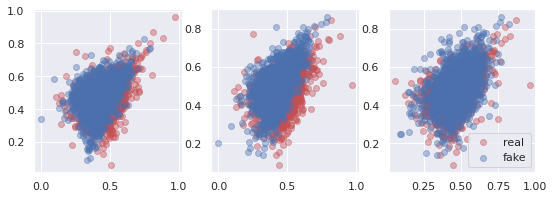

Epoch: 3000


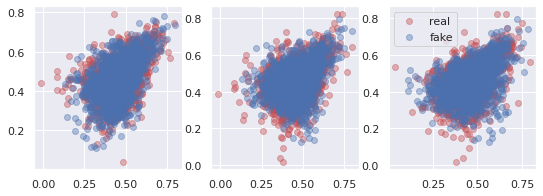

Epoch: 3500


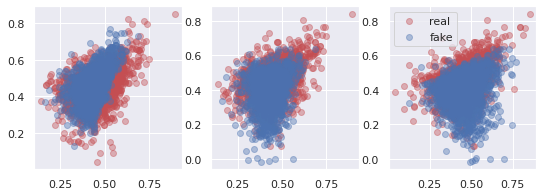

Epoch: 4000


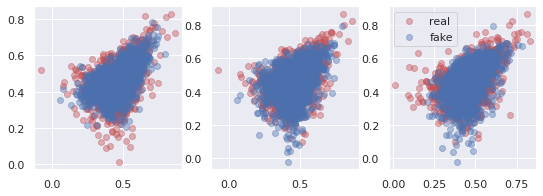

Epoch: 4500


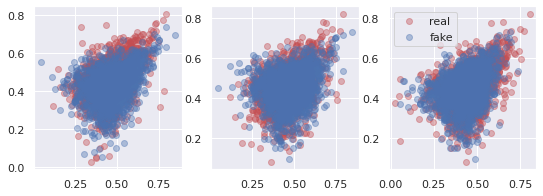

Epoch: 5000


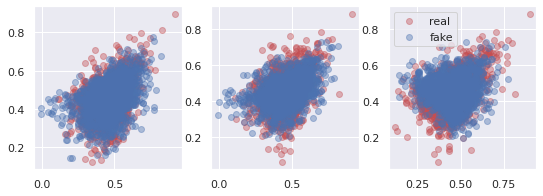

Epoch: 5500


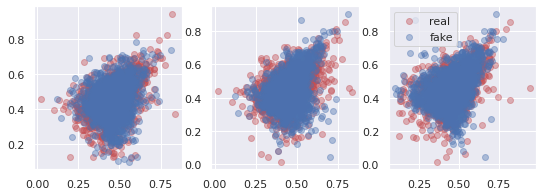

Epoch: 6000


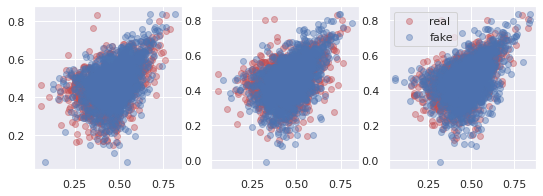

Epoch: 6500


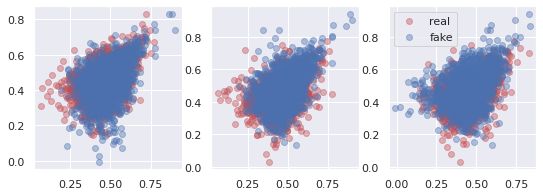

Epoch: 7000


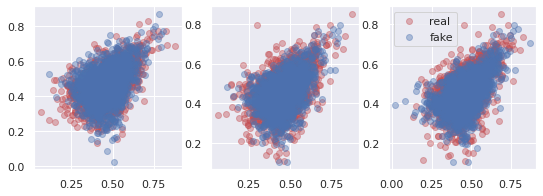

Epoch: 7500


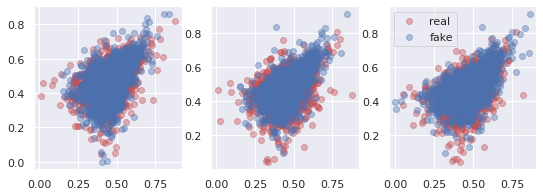

Epoch: 8000


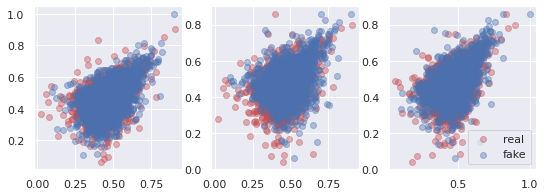

Epoch: 8500


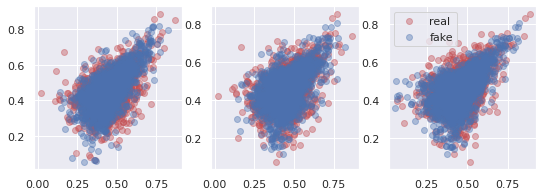

Epoch: 9000


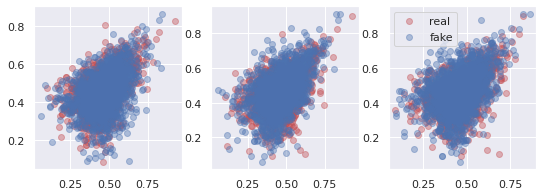

Epoch: 9500


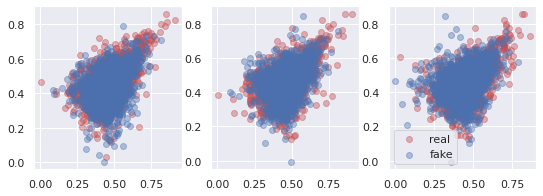

Epoch: 10000


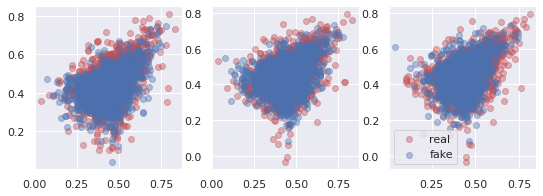

Epoch: 10500


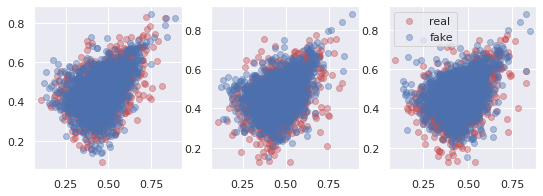

Epoch: 11000


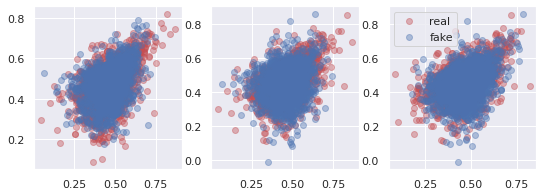

Epoch: 11500


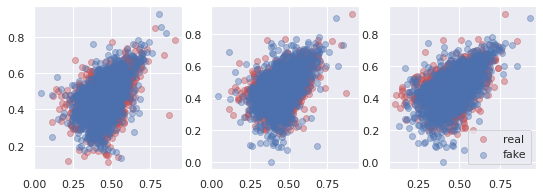

Epoch: 12000


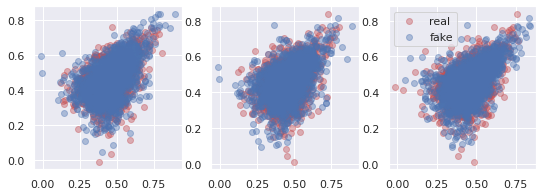

Epoch: 12500


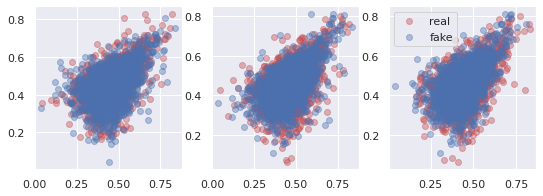

Epoch: 13000


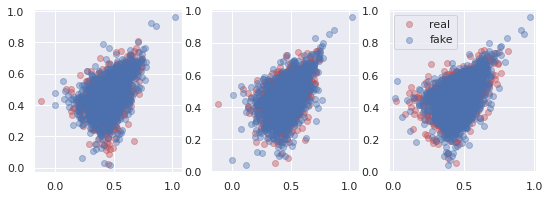

Epoch: 13500


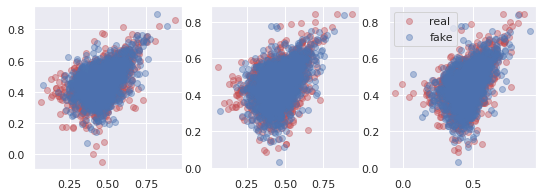

Epoch: 14000


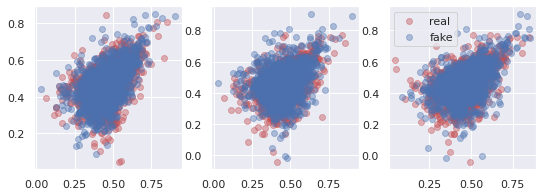

Epoch: 14500


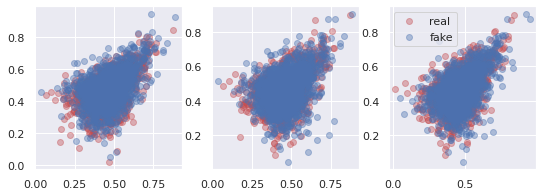

Epoch: 15000


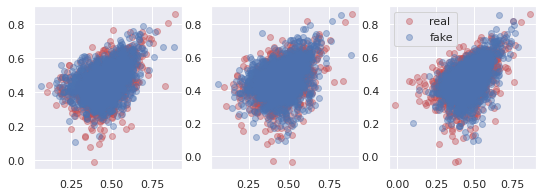

Epoch: 15500


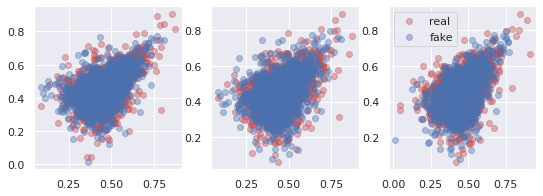

Epoch: 16000


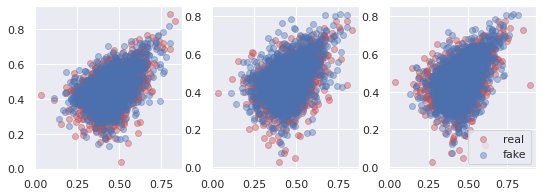

Epoch: 16500


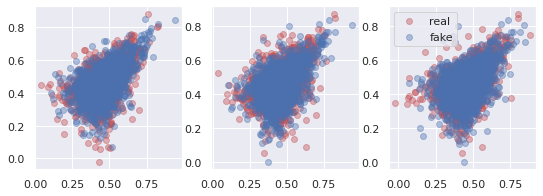

Epoch: 17000


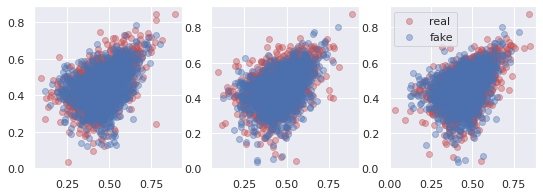

Epoch: 17500


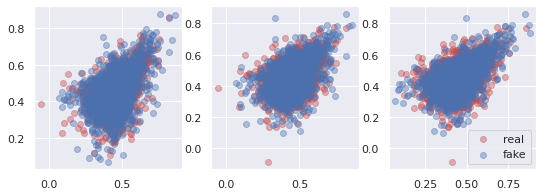

Epoch: 18000


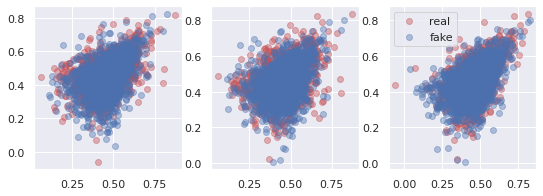

Epoch: 18500


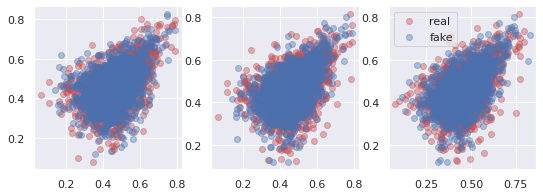

Epoch: 19000


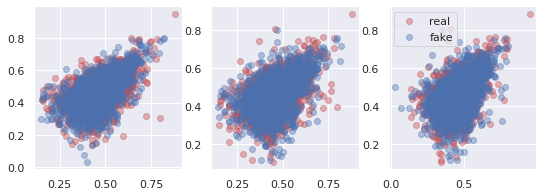

Epoch: 19500


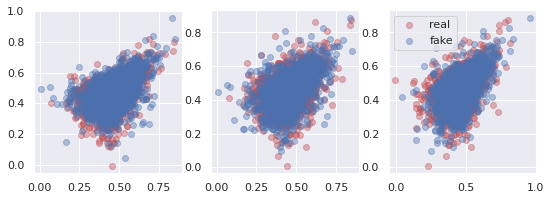

Epoch: 20000


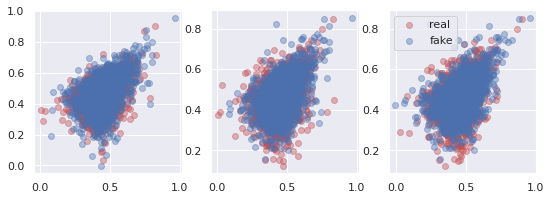

Epoch: 20500


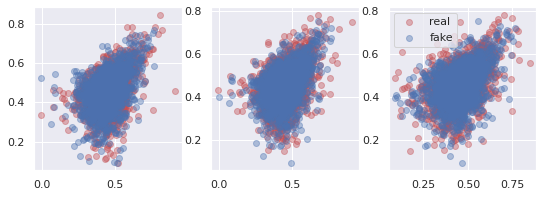

In [3]:
m1=[[],[]]
m2=[[],[]]
real_shuffle_acc=[[],[]]
fake_shuffle_acc=[[],[]]
g_loss=[[],[]]
d_loss=[[],[]]

warnings.filterwarnings('ignore')

# define the standalone discriminator model
def define_discriminator():
    model = Sequential()
    model.add(Dense(100, input_shape=(1,3)))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(500))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(500))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = optimizers.RMSprop(lr=0.0001, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(100, input_shape=[latent_dim]))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(100))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(300))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(200))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(3))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Reshape((1,3)))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = optimizers.Adam(lr=0.00005, decay=1e-5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# generate n real samples with class labels
def generate_real_samples(n_samples):
    dataset = np.log(np.array([generate_gaps(3) for _ in range(n_samples)])) / 20    
    dataset = dataset.reshape(-1,1,3)
    y=ones((n_samples,1))
    return dataset, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=2000):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    x_fake = x_fake.reshape(n,3)
    x_real = x_real.reshape(n,3)
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    plt.scatter(x_real[:,0],x_real[:,1],alpha=0.4,color='r', label='real')
    plt.scatter(x_fake[:,0],x_fake[:,1],alpha=0.4,color='b', label='fake')  
    plt.subplot(1,3,2)
    plt.scatter(x_real[:,0],x_real[:,2],alpha=0.4,color='r', label='real')
    plt.scatter(x_fake[:,0],x_fake[:,2],alpha=0.4,color='b', label='fake') 
    plt.subplot(1,3,3)
    plt.scatter(x_real[:,1],x_real[:,2],alpha=0.4,color='r', label='real')
    plt.scatter(x_fake[:,1],x_fake[:,2],alpha=0.4,color='b', label='fake') 
    print("Epoch:",epoch)
    plt.legend()
    plt.show()

def smooth_positive_labels(y):
    return y - 0.3 + (random(y.shape) * 0.5)
def smooth_negative_labels(y):
    return y + 0.3 + (random(y.shape) * 0.3)


# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=21000, n_batch=256, n_eval=500):
    # determine half the size of one batch, for updating the discriminator
    bat_per_eop = int(5000 / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_eop):
            # prepare real samples
            x_real, y_real = generate_real_samples(half_batch)
            # prepare fake examples
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            y_real = smooth_positive_labels(y_real)
            y_fake = smooth_negative_labels(y_fake)
            # update discriminator
            loss_1=d_model.train_on_batch(x_real, y_real)
            loss_2=d_model.train_on_batch(x_fake, y_fake)
            # prepare points in latent space as input for the generator
            x_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            y_gan = smooth_positive_labels(y_gan)
            # update the generator via the discriminator's error
            loss_3=gan_model.train_on_batch(x_gan, y_gan)
            d_loss.append(loss_1[0]+loss_2[0])
            g_loss.append(loss_3)
            # evaluate the model every n_eval epochs
        if (i) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 30
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)